<a href="https://colab.research.google.com/github/sanduerhan/Licenta/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset Import

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

In [ ]:
!pip install --upgrade numpy

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import openpyxl
from nltk.corpus import stopwords, words, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize, word_tokenize
from gensim.models import Word2Vec
import gensim
import re, string
from string import punctuation, digits

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler


from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import one_hot,Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.initializers import Constant
from tensorflow.keras import layers
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Flatten ,Embedding,Input,LSTM
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

col_list = ["Column2", "Column3"]
dataset = pd.read_excel("Training.data.xlsx", usecols=col_list)
testset = pd.read_excel("Dev.xlsx", usecols=col_list)


def add_category_id(dataset):
  dataset['category_id'] = dataset['Column3'].factorize()[0]
  category_id_dataset = dataset[['Column3', 'category_id']].drop_duplicates()

  category_to_id = dict(category_id_dataset.values)
  id_to_category = dict(category_id_dataset[['category_id', 'Column3']].values)
  return dataset,category_to_id, id_to_category

dataset, category_to_id_train, id_to_category_train = add_category_id(dataset)
testset, category_to_id_test, id_to_category_test = add_category_id(testset)
dataset = dataset.sample(frac = 1)
testset = testset.sample(frac = 1)
train_x = dataset["Column2"]
train_y = dataset["category_id"]
test_x = testset["Column2"]
test_y = testset["category_id"]


In [ ]:
print(train_x[7412])

In [ ]:
train_tweets = dataset['Column2'].tolist()
test_tweets = testset['Column2'].tolist()
def keep_uniques(array, df):
    dels=[]
    for i in array:
        if array.count(i)>1:
            dels.append(i)
    dels=list(set(dels))
    for i in dels:
        df.drop( df[ df['Column2'] == i ].index, inplace=True)
    return df

dataset = keep_uniques(train_tweets, dataset)
testset = keep_uniques(test_tweets, testset)

print(len(testset))

4062


In [ ]:
# fig = plt.figure(figsize=(8,6))
colors = ['lightblue','blue','darkblue']

train_mean = dataset.groupby('Column3').Column2.count().sort_values()
print(train_mean)
test_mean = testset.groupby('Column3').Column2.count().sort_values()
X = ['Antrenare','Validare']
severe_mean = [train_mean[0], test_mean[0]]
not_mean = [train_mean[1], test_mean[1]]
moderate_mean = [train_mean[2], test_mean[2]]
X_axis = np.arange(len(X))

plt.bar(X_axis , moderate_mean, 0.2, label = 'Moderat',color ="darkblue")
plt.bar(X_axis + 0.2, not_mean, 0.2, label = 'Fără depresie',color = 'blue')
plt.bar(X_axis + 0.2*2, severe_mean, 0.2, label = 'Sever',color = 'lightblue')
  
plt.xticks(X_axis, X)
plt.ylabel("Număr de apariții")
plt.title("Tweeturi per categorie")
plt.legend()
plt.show()

No handles with labels found to put in legend.


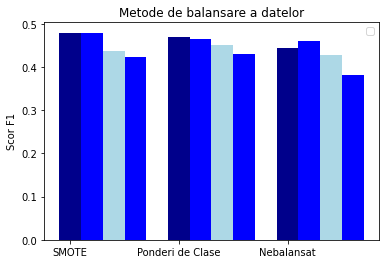

In [ ]:
X = ['SMOTE', 'Ponderi de Clase', 'Nebalansat']
vec1 = [0.4224,0.4297, 0.3807]
vec2 = [0.4375,0.4505,0.4275]
vec3 = [0.4793,0.4643, 0.4612]
vec4 = [0.4776,0.4690, 0.4441]
X_axis = np.arange(3)

plt.bar(X_axis , vec4, 0.2, color ="darkblue")
plt.bar(X_axis + 0.2, vec3, 0.2, color = 'blue')
plt.bar(X_axis + 0.2*2, vec2, 0.2, color = 'lightblue')
plt.bar(X_axis + 0.2*3, vec1, 0.2, color = 'blue')
plt.xticks(X_axis, X)
plt.ylabel("Scor F1")
plt.title("Metode de balansare a datelor")
plt.legend()
plt.show()

# PreProcessing

In [ ]:
!pip install tweet-preprocessor
import preprocessor as p

def preprocess_tweets(text):
  return p.clean(text)

print(preprocess_tweets(train_x[7412]))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Today i want to kill myself.... : Because i'm i alone and no one loves me anymore :'(


In [ ]:
# cleaning the text : deleting the emojis, the existing emails, the punctuation, the present digits,
# the hyperlinks and the stopwords (a,the,is, etc)

def delete_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", re.UNICODE)
    return emoji_pattern.sub(r'', text)  # no emoji


def delete_digits(text):
    text = text.lower()
    clean = text.translate(str.maketrans('', '', digits))
    return clean


def delete_punctuation(text):
    clean = text.translate(str.maketrans('', '', punctuation + '’“”'))
    return clean


stop = set(stopwords.words('english'))
stop.add('gtpoplt')
stop.add('new')
stop.add('year')
stop.add('eve')
stop.add('years')
stop.add('ti')
stop.add('ame')
stop.add('folks')
punct = list(string.punctuation)
stop.update(punct)


def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)


def remove_hyperlinks(text):
    for word in text:
        if re.match(r'^http', word):
            text.remove(word)
    return " ".join(text)

def remove_emails(text):
    text = text.split()
    for i in text:
        if '@' in i.strip().lower():
            text.remove(i)
    return " ".join(text)

contraction_dict = {"youre":"you are","im": "i am","wouldnt": "would not","itll": "it will","wasnt": "was not","dont": "do not","ill": "i will","isnt": "is not","cant": "cannot","arent": "are not","ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re
contractions, contractions_re = _get_contractions(contraction_dict)
def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

# def denoise_text(text):
#     text = replace_contractions(text)
#     text = remove_words(text)
#     text = remove_emails(text)
#     text = delete_punctuation(text)
#     text = delete_emoji(text)
#     text = delete_digits(text)
#     text = remove_stopwords(text)
#     text = text.split()
#     text = remove_hyperlinks(text)
#     return text



train_x = dataset["Column2"]
train_y = dataset["category_id"]
test_x = testset["Column2"]
test_y = testset["category_id"]

for i in range(len(train_x)):
  train_x[i] = replace_contractions(train_x[i])
  train_x[i] = remove_emails(train_x[i])
  train_x[i] = delete_punctuation(train_x[i])
  train_x[i] = delete_emoji(train_x[i])
  train_x[i] = delete_digits(train_x[i])
  train_x[i] = remove_stopwords(train_x[i])

for i in range(len(test_x)):
  test_x[i] = replace_contractions(test_x[i])
  test_x[i] = remove_emails(test_x[i])
  test_x[i] = delete_punctuation(test_x[i])
  test_x[i] = delete_emoji(test_x[i])
  test_x[i] = delete_digits(test_x[i])
  test_x[i] = remove_stopwords(test_x[i])



In [ ]:
print(train_x[7449])
print(dataset["Column2"])

# Lemmatization

In [ ]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


True

In [ ]:
# lemmatization : crying -> cry, days -> day

def get_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


def lemm(text):
    text = text.split()
    lemmatizer = WordNetLemmatizer()
    sar_list_lemmatizer = [lemmatizer.lemmatize(word, get_pos(word)) for word in text]
    return " ".join(sar_list_lemmatizer)

In [ ]:
train_x = train_x.apply(lemm)
test_x = test_x.apply(lemm)

In [ ]:
print(train_x[7429])

In [ ]:
plt.figure(figsize=(12,6))
text = ' '.join(train_x[dataset['Column3']=='severe'])
wc = WordCloud(background_color='white').generate(text)
plt.imshow(wc)

# Count Vectorizer

In [ ]:
# CountVectorizer reprezentation for the user tweets
def count_vec(train,test):
  vectorizer = CountVectorizer()
  x_train_cv = vectorizer.fit_transform(train)

  x_test_cv = vectorizer.transform(test)
  return x_train_cv, x_test_cv

(8068, 10252)


In [ ]:
x_train_cv, x_test_cv = count_vec(train_x, test_x)

# Data imbalance handling

In [ ]:
sm = SMOTE(random_state = 42)
res_x, res_y = sm.fit_resample(x_train_cv, train_y)
print("After OverSampling, counts of label '2': {}".format(sum(res_y == 2)))

After OverSampling, counts of label '2': 5647


In [ ]:
os = RandomOverSampler()
res_x2, res_y2 = os.fit_resample(x_train_cv, train_y)

# Tf-Idf 

In [ ]:
# Tf-idf reprezentation for the tweets
def tf_idf(train, test, y):
  vectorizer = TfidfVectorizer(max_df = 0.15,min_df = 5, ngram_range=(1,2), stop_words='english')
  train_x_tf = vectorizer.fit_transform(train)
  test_x_tf = vectorizer.transform(test)

  res_tfx, res_tfy = sm.fit_resample(train_x_tf, y)
  return train_x_tf, test_x_tf, res_tfx, res_tfy

(8068, 33909)
(16941, 33909)


In [ ]:
train_x_tf, test_x_tf, res_tfx, res_tfy = tf_idf(train_x, test_x, train_y)

# Word2Vec

In [ ]:
sent = [row.split() for row in train_x]

In [ ]:
from gensim.models.phrases import Phrases, Phraser

In [ ]:
bigram = Phraser(phrases)
sentences = bigram[sent]

In [ ]:
print(sentences)

In [ ]:
w2v_model = Word2Vec(min_count=20,
                     window=5,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     )

In [ ]:
w2v_model.build_vocab(sentences)

In [ ]:
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

In [ ]:
w2v_model.wv.most_similar(positive=["depression"])

In [ ]:
model,word_index,pad_rev_train = word2(train_x)

In [ ]:
model2,word_index2,pad_rev_test = word2(test_x)

In [ ]:
def get_weight_matrix(model, vocab):
    vocab_size = len(vocab) + 1
    weight_matrix = np.zeros((vocab_size, 300))
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

In [ ]:
embedding_vectors = get_weight_matrix(model, word_index)

In [ ]:
def w2v_embedding(train_text):

  lst_corpus = []
  for string in train_text:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) 
                for i in range(0, len(lst_words), 1)]
    lst_corpus.append(lst_grams)

  bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, 
                  delimiter=" ".encode(), min_count=30)
  bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)
  trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], 
              delimiter=" ".encode(), min_count=30)
  trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

  nlp = Word2Vec(lst_corpus, size=300,   
            window=8, min_count=2, sg=1, iter=30)
  return nlp, lst_corpus, bigrams_detector, trigrams_detector

In [ ]:
def feature_engineering(lst_corpus, train_text):
  tokenizer = Tokenizer(lower=True, split=' ', 
                     oov_token="NaN", 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
  tokenizer.fit_on_texts(lst_corpus)
  dic_vocabulary = tokenizer.word_index

  lst_corpus = []
  for string in train_text:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) 
                for i in range(0, len(lst_words), 1)]
    lst_corpus.append(lst_grams)
  lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)

  X_train = pad_sequences(lst_text2seq, 
                      maxlen=30, padding="post", truncating="post")
  return tokenizer, dic_vocabulary, X_train

In [ ]:
def make_embedding_matrix(dic_vocabulary, nlp):
  embeddings = np.zeros((len(dic_vocabulary)+1, 300))
  for word,idx in dic_vocabulary.items():
      try:
          embeddings[idx] =  nlp[word]
      except:
          pass
  return embeddings

In [ ]:
nlp, lst_corpus, bigrams_detector, trigrams_detector = w2v_embedding(train_x)

In [ ]:
print(nlp.wv.most_similar(positive="depression"))

[('ocdanxiety', 0.3492339253425598), ('anxiety', 0.3416626453399658), ('diagnose', 0.33797287940979004), ('longstanding', 0.3372364044189453), ('actor', 0.33621853590011597), ('stabilizer', 0.334298312664032), ('crucial', 0.33266133069992065), ('microdosing', 0.3280254006385803), ('selenium', 0.32584166526794434), ('sought', 0.32460087537765503)]


In [ ]:
tokenizer, dic_vocabulary, X_train = feature_engineering(lst_corpus,train_x)

In [ ]:
print(X_train.shape)

(8068, 30)


In [ ]:
embeddings_train = make_embedding_matrix(dic_vocabulary, nlp)

In [ ]:
def test_handling(test_text,bigrams_detector, trigrams_detector, tokenizer):

  lst_corpus = []
  for string in test_text:
      lst_words = string.split()
      lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
                  len(lst_words), 1)]
      lst_corpus.append(lst_grams)

  lst_corpus = list(bigrams_detector[lst_corpus])
  lst_corpus = list(trigrams_detector[lst_corpus])

  lst_text2seq = tokenizer.texts_to_sequences(lst_corpus)

  X_test = pad_sequences(lst_text2seq, maxlen=30,
              padding="post", truncating="post")
  return X_test

In [ ]:
nlp2, lst_corpus2, bigrams_detector2, trigrams_detector2 = w2v_embedding(test_x)

In [ ]:
x_test = test_handling(test_x, bigrams_detector2, trigrams_detector2, tokenizer)

In [ ]:
print(x_test.shape)

(4078, 30)


# Naive Bayes

In [ ]:
def naive_bayes(train_x, train_y, test_x, test_y):
  naive_bayes_classifier = MultinomialNB()
  naive_bayes_classifier.fit(train_x, train_y)
  pred_y = naive_bayes_classifier.predict(test_x)

  score1 = metrics.accuracy_score(test_y, pred_y)
  print("Accuracy " + str(score1))
  print(metrics.classification_report(test_y, pred_y, digits = 4))

In [ ]:
naive_bayes(res_x, res_y, x_test_cv, test_y)

In [ ]:
naive_bayes(x_train_cv, train_y, x_test_cv, test_y)

In [ ]:
naive_bayes(res_tfx, res_tfy, test_x_tf, test_y)

In [ ]:
naive_bayes(res_tfx, res_tfy, test_x_tf, test_y)

# AdaBoost

In [ ]:

def adaboost(train_x, train_y, test_x, test_y):
  ada = AdaBoostClassifier()
  boost = ada.fit(train_x, train_y)
  pred_y = boost.predict(test_x)
  print("AdaBoost Classifier Model Accuracy:", accuracy_score(test_y, pred_y))
  print(metrics.classification_report(test_y, pred_y))

In [ ]:
adaboost(res_x, res_y, x_test_cv, test_y)

In [ ]:
adaboost(x_train_cv, train_y, x_test_cv, test_y)

In [ ]:
adaboost(res_tfx, res_tfy, test_x_tf, test_y)

In [ ]:
adaboost(res_tfx, res_tfy, test_x_tf, test_y)

# Regression

In [ ]:
class_weight = {0: 1.,
                1: 3.,
                2: 4.}

def logistic_regression(train_x, train_y, test_x, test_y):
  model = LogisticRegression(multi_class='multinomial', solver='newton-cg')

  model = model.fit(train_x, train_y)
  y_pred = model.predict(test_x)

  print("Regression Classifier Model Accuracy:", accuracy_score(test_y, y_pred))
  print(metrics.classification_report(test_y, y_pred, digits = 4))

  conf_mat = confusion_matrix(test_y, y_pred)
  print(conf_mat)


In [ ]:
logistic_regression(res_x, res_y, x_test_cv, test_y)

In [ ]:
logistic_regression(x_train_cv, train_y, x_test_cv, test_y)

In [ ]:
logistic_regression(res_tfx, res_tfy, test_x_tf, test_y)

In [ ]:
logistic_regression(res_tfx, res_tfy, test_x_tf, test_y)

# SVM

In [ ]:

class_weight = {0: 1.,
                1: 3.,
                2: 6.}

def svm(train_x, train_y, test_x, test_y):
  model = LinearSVC()
  model = model.fit(train_x_tf, train_y)
  y_pred = model.predict(test_x_tf)
  
  print("Svc Classifier Model Accuracy:", accuracy_score(test_y, y_pred))
  print(metrics.classification_report(test_y, y_pred, digits = 4))

  conf_mat = confusion_matrix(test_y, y_pred)
  print(conf_mat)


In [ ]:
svm(res_x, res_y, x_test_cv, test_y)

In [ ]:
svm(x_train_cv, train_y, x_test_cv, test_y)

In [ ]:
svm(res_tfx, res_tfy, test_x_tf, test_y)

In [ ]:
svm(res_tfx, res_tfy, test_x_tf, test_y)

# F1 metric

In [ ]:

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [ ]:
def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

# Neural Network

In [ ]:
class_weight = {0: 1.,
                1: 3.,
                2: 5.}
# def split(pad_rev,train_y):
#   Y=keras.utils.to_categorical(train_y)  # one hot target as required by NN.
#   x_train,x_test,y_train,y_test=train_test_split(pad_rev,Y,test_size=0.05,random_state=42)
#   return x_train, x_test,y_train,y_test
def network(embeddings):
 ## input
  x_in = layers.Input(shape=(30,))
  ## embedding
  x = layers.Embedding(input_dim=embeddings.shape[0],  
                      output_dim=embeddings.shape[1], 
                      weights=[embeddings],
                      input_length=30, trainable=False)(x_in)
  ## 2 layers of bidirectional lstm
  x = layers.Bidirectional(layers.LSTM(units=30, dropout=0.2, 
                          return_sequences=True))(x)
  x = layers.Bidirectional(layers.LSTM(units=30, dropout=0.2))(x)
  ## final dense layers
  x = layers.Dense(64, activation='elu')(x)
  y_out = layers.Dense(3, activation='softmax')(x)
  ## compile
  model = Model(x_in, y_out)
  model.compile(loss=f1_loss,
                optimizer='adam', metrics=[f1])
  return model
Y=keras.utils.to_categorical(train_y)
Y2=keras.utils.to_categorical(test_y)
# x_train,x_test,y_train,y_test = split(X_train,train_y)
model = network(embeddings_train)
# x_valid, x_x, y_valid, y_y = split(x_test,test_y)
model.fit(X_train, Y, epochs=10, batch_size=64, validation_data=(x_test,Y2))


In [ ]:
model.summary()

In [ ]:
pred_y = model.predict(x_test)
pred_y = np.argmax(pred_y, axis=1)
# y_test=np.argmax(y_test, axis=1)
print(metrics.classification_report(test_y, pred_y, digits = 4))

conf_mat = confusion_matrix(test_y, pred_y)
print(conf_mat)

# BERT

In [ ]:
!pip install transformers

In [ ]:
!pip install sentence_transformers
from sentence_transformers import SentenceTransformer

In [ ]:
from keras.initializers import GlorotNormal
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from transformers import RobertaTokenizer

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [ ]:
text_train = train_x.astype(str).tolist()
text_test = test_x.astype(str).tolist()

In [ ]:
s = tokenizer.tokenize(train_x)
embt = tokenizer.encode(s)

In [ ]:
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification,Trainer, TrainingArguments

In [ ]:
model = RobertaForSequenceClassification.from_pretrained('roberta-base')
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base', max_length = 512)

In [ ]:
!pip install datasets

In [ ]:
!pip install pandas

In [ ]:
!pip install load_dataframe

In [ ]:
import pandas as pd

In [ ]:
model = SentenceTransformer("all-mpnet-base-v2")

In [ ]:
def sentence(texts):
  model = SentenceTransformer("all-mpnet-base-v2")
  embeddings = model.encode(texts)

  return embeddings

In [ ]:
TRANSFORMER_BATCH=128

def count_embedd (df):
    idx_chunk=list(df.columns).index('Column2')
    embedd_lst = []
    for index in range (0, len(df), TRANSFORMER_BATCH):
        embedds = model.encode(df.iloc[index:index+TRANSFORMER_BATCH, idx_chunk].values, show_progress_bar=False)
        embedd_lst.append(embedds)
    return np.concatenate(embedd_lst)

In [ ]:
train_emb = count_embedd(dataset)

In [ ]:
test_emb = count_embedd(testset)

In [ ]:
X_train = np.array(train_emb)
X_test = np.array(test_emb)

In [ ]:
y_train=keras.utils.to_categorical(train_y)

In [ ]:
KERAS_VALIDATION_SPLIT=0.00
KERAS_EPOCHS=10
KERAS_BATCH_SIZE=128

class_weight = {0: 1.,
                1: 3.,
                2: 6.}

# Create and train Keras model
n_features=X_train.shape[1]
n_labels = y_train.shape[1]

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(2048, input_dim=n_features),
  tf.keras.layers.LeakyReLU(alpha=0.01),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(64),
  tf.keras.layers.LeakyReLU(alpha=0.01),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(3, activation='softmax')
])

LR=5e-4
adam = keras.optimizers.Adam(learning_rate=LR, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(optimizer=adam, 
              loss="categorical_crossentropy",
              metrics=[f1])

model.fit(X_train, y_train, epochs=KERAS_EPOCHS, batch_size=KERAS_BATCH_SIZE, validation_split=KERAS_VALIDATION_SPLIT)

In [ ]:
model.summary()


In [ ]:
y_preds = model.predict(X_test)
predicted = np.argmax(y_preds,axis=1) 
accuracy = metrics.accuracy_score(test_y, predicted)
print("Accuracy:",  round(accuracy,4))
print(metrics.classification_report(test_y, predicted,digits=4))

conf_mat = confusion_matrix(test_y, predicted)
print(conf_mat)

# BERT2

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/MyDrive/content/drive")
!ls

FileNotFoundError: ignored

In [ ]:
import pickle
from transformers import AutoModel, AdamW, AutoTokenizer, get_scheduler
from torch.utils.data import DataLoader, TensorDataset, Dataset, RandomSampler
import torch
from sklearn.utils import class_weight
import numpy as np
import torch.nn as nn
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn import metrics
from sklearn.metrics import f1_score

In [ ]:
embedding_config = {
    "model_name": "cardiffnlp/twitter-roberta-base-sentiment",
    # "path":"/content/drive/MyDrive/content/drive/models/twitter-roberta-base-sentiment-new",
    "max_length":40,
    "batch_size":16,
    "source":"HuggingFace"
}

In [ ]:
model_config = {
    "learning_rate" : 2e-5,
    "weight_decay":0.01,
    "epochs":20
}

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
class_weights = class_weight.compute_class_weight(class_weight="balanced", classes = np.unique(dataset["Column3"]), y=np.array(dataset["Column3"]))
print(class_weights)

[0.47624107 1.71842386 3.14174455]


In [ ]:
class BertClassfierPytorch(nn.Module):
  def __init__(self, input_size = 768, output_size = 3):
    super().__init__()
    print(input_size)
    self.name = embedding_config["model_name"]
    self.tokenizer = AutoTokenizer.from_pretrained(embedding_config["model_name"], use_fast=False)
    self.embedder=AutoModel.from_pretrained(embedding_config["model_name"])
    self.dropout=nn.Dropout(0.5)
    self.classifier=nn.Linear(input_size, output_size)
    nn.init.xavier_uniform_(self.classifier.weight)

In [ ]:
def normalize(predicted):
  opt_threshold=0.5
  predicted = [threshold(pred, opt_threshold) for pred in 
              predicted]
  return predicted

def evaluate_predictions(predictions, labels):
  metrics.confusion_matrix(labels, predictions)
  print(metrics.classification_report(labels, predictions, digits=4))
  return f1_score(labels, predictions, average='macro')

def normalize_threshold(predicted, y_test):
  #opt_threshold=-2.850132
  opt_threshold = 0.5
  #opt_threshold = roc_curve_threshold(predicted, y_test)
  #opt_threshold = max_f1_threshold(model,predicted_prob, y_test, X_test)
  opt_threshold = pr_curve_threshold(predicted, y_test)
  #opt_threshold = pr_curve_threshold(model.predict(X_train), y_train)
  # opt_threshold = opt_threshold_tuning(predicted_prob, y_test)
  predicted = [threshold(pred, opt_threshold) for pred in 
              predicted]
  return predicted

In [ ]:
def evaluate(model, x_test, y_test):
  x_test = model.tokenizer(x_test, padding  = "max_length", max_length = embedding_config["max_length"], truncation = True, return_tensors = "pt")
  test_data = TensorDataset(x_test["input_ids"], x_test["attention_mask"], torch.FloatTensor(y_test))

  batch_size = embedding_config["batch_size"]
  test_dataloader = DataLoader(test_data, batch_size=batch_size)

  preds=[]
  model.eval()
  for batch in test_dataloader:
    aux_batch = {
        "input_ids" : batch[0].to(device),
        "attention_mask" : batch[1].to(device)
    }

    with torch.no_grad():
      outputs = model.embedder(**aux_batch).pooler_output
      outputs = model.classifier(model.dropout(outputs))

    preds+=outputs.sigmoid().round().reshape(-1).tolist()
    #preds+=outputs.reshape(-1).tolist()
  
  # predictions = normalize(preds)
  # predictions = normalize_threshold(preds, y_test)
  return evaluate_predictions(preds, y_test)

In [ ]:
def train_model(model, x_train, y_train, x_valid, y_valid):
  max_score = 0
  
  x_train = model.tokenizer(x_train, padding  = "max_length", max_length = embedding_config["max_length"], truncation = True, return_tensors = "pt")
  train_data = TensorDataset(x_train["input_ids"], x_train["attention_mask"], torch.FloatTensor(y_train))

  batch_size = embedding_config["batch_size"]
  train_dataloader = DataLoader(train_data, batch_size=batch_size)

  num_epochs = model_config["epochs"]
  num_training_steps = num_epochs * len(train_dataloader)

  optimizer = AdamW(model.parameters(), lr = model_config["learning_rate"], weight_decay = model_config["weight_decay"])

  lr_scheduler = get_scheduler(
      "linear",
      optimizer = optimizer,
      num_warmup_steps = 0.2*num_training_steps,
      num_training_steps = num_training_steps
  )

  print("Steps ",num_training_steps)

  progress_bar = tqdm(range(num_training_steps))

  model.train()
  losses = []

  for epoch in range(num_epochs):
    model.train()
    print("Epoch: ", epoch+1)
    for batch in train_dataloader:
      aux_batch = {
        "input_ids" : batch[0].to(device),
        "attention_mask" : batch[1].to(device)
      }

      outputs = model.embedder(**aux_batch).pooler_output
      outputs = model.classifier(model.dropout(outputs))

      criterion = nn.CrossEntropyLoss()#??????????
      loss = criterion(outputs, batch[2].to(device).reshape(-1,1))

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      lr_scheduler.step()
      progress_bar.update(1)

    losses.append(loss.tolist())
    score =  evaluate(model, x_valid, y_valid)
    if score>max_score:
      max_score = score
      #torch.save(model.state_dict(), embedding_config["path"]+".pt")  
  return num_training_steps, losses

In [ ]:
model = BertClassfierPytorch()
model.to(device)

In [ ]:
text_train = train_x.astype(str).tolist()
text_test = test_x.astype(str).tolist()

In [ ]:
print(type(train_x))

<class 'pandas.core.series.Series'>


In [ ]:
num_training_steps, losses = train_model(model, text_train, train_y, text_test, test_y)

Steps  10100


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/10100 [00:00<?, ?it/s]

Epoch:  1


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.5855    0.4299    0.4958      2198
           1     0.3762    0.6091    0.4651      1522
           2     0.0000    0.0000    0.0000       358

    accuracy                         0.4590      4078
   macro avg     0.3206    0.3463    0.3203      4078
weighted avg     0.4560    0.4590    0.4408      4078

Epoch:  2


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.5855    0.4299    0.4958      2198
           1     0.3762    0.6091    0.4651      1522
           2     0.0000    0.0000    0.0000       358

    accuracy                         0.4590      4078
   macro avg     0.3206    0.3463    0.3203      4078
weighted avg     0.4560    0.4590    0.4408      4078

Epoch:  3


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0     0.5855    0.4299    0.4958      2198
           1     0.3762    0.6091    0.4651      1522
           2     0.0000    0.0000    0.0000       358

    accuracy                         0.4590      4078
   macro avg     0.3206    0.3463    0.3203      4078
weighted avg     0.4560    0.4590    0.4408      4078

Epoch:  4


KeyboardInterrupt: ignored